<div style="
    background-color: #1a1a1a; 
    padding: 40px; 
    border-radius: 20px; 
    text-align: center; 
    font-family: 'Garamond', serif; 
    box-shadow: 0 6px 18px rgba(0, 0, 0, 0.8); 
    color: white;">
    

<div style="
        font-size: 1.2em; 
        color: #BFA86A; 
        font-weight: bold; 
        letter-spacing: 2px;">
        ✦ A CINEMATIC EXPERIENCE ✦
</div>   

<h1 style="
        font-size: 3.2em; 
        margin: 20px 0; 
        color: #E3D9B6; 
        font-weight: bold; 
        text-transform: uppercase;">
        Money, Money, Movies
</h1>    

<h2 style="
        font-size: 2em; 
        margin: 10px 0; 
        font-style: italic; 
        color: #D4C593;">
        The Secrets of Movies' Box Office Success
</h2>

    
<div style="
        font-size: 1em; 
        color: #999; 
        margin-top: 20px;">
        🎥 A Production by <strong style="color: #E3D9B6;">C1n3mada Studios</strong>
</div>
</div>


### Importing Libraries

In [1]:
import ast
import warnings
from collections import Counter
from itertools import chain

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from IPython.display import clear_output
from ipywidgets import interact, widgets
from scipy import stats
from scipy.stats import f_oneway, pearsonr, spearmanr
from statsmodels.formula.api import ols
from tabulate import tabulate

from src.utils.evaluation_utils import validate_dataframes

from src.utils.analysis_utils import (
    genre_correlation,
    extract_names,
    extract_first_language,
    extract_first_country,
    get_movies_with_genres,
    calculate_count_revenue_correlation
)

from src.utils.data_utils import (
    prepare_df_for_rating_analysis,
    prepare_df_for_genre_analysis,
    prepare_df_for_budget_analysis,
    # clean_dataframes,
    prepare_director_data,
    prepare_seasonal_data,
)

from src.utils.plot_utils import (
    plot_genre_barplot,
    plot_distribution,
    plot_scatter,
    plot_correlation_heatmap,
    plot_genre_correlation_bars,
    # plot_budget_revenue_trend,
    create_treemap,
    create_animated_treemap,
    revenue_formatter,
)

from src.utils.interactive_plots_utils_said import (
    plot_budget_and_revenue_distributions,
    plot_budget_revenue_over_time,
    plot_roi_distribution,
    plot_roi_by_genre,
    plot_roi_per_genre_boxplot,
    plot_budget_per_genre,
    plot_revenue_to_budget_ratio,
    plot_budget_correlation_per_genre,
    plot_budget_vs_revenue
)



warnings.filterwarnings("ignore")
%matplotlib inline
# auto-reload modules
%load_ext autoreload
%autoreload 2

# TODO: Should this stay here?
# Plot configurations
sns.set_theme(style="white", palette="colorblind")

# TODO: REMOVE THIS IN THE END (for interactive plots)
from src.utils.interactive_plots_utils import *

### Loading the Dataset

In [2]:
# load the dataset
PATH = "data/processed/movies_processed.csv"
df = pd.read_csv(PATH)

df.head()

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,release_year,...,combined_revenue,release_month,release_day,primaryTitle,startYear,averageRating,numVotes,director,inflated_revenue,inflated_budget
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"[('/m/02h40lc', 'English Language')]","[('/m/09c7w0', 'United States of America')]","[('/m/01jfsb', 'Thriller'), ('/m/06n90', 'Scie...",2001.0,...,14010832.0,8.0,24.0,Ghosts of Mars,2001.0,4.9,58868.0,John Carpenter,1.899115e+07,3.795294e+07
1,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"[('/m/02h40lc', 'English Language')]","[('/m/09c7w0', 'United States of America')]","[('/m/04t36', 'Musical'), ('/m/01z4y', 'Comedy...",1938.0,...,3600000.0,8.0,16.0,Alexander's Ragtime Band,1938.0,6.8,2357.0,Henry King,6.131466e+07,3.406370e+07
2,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"[('/m/02h40lc', 'English Language')]","[('/m/07ssc', 'United Kingdom')]","[('/m/04xvh5', 'Costume drama'), ('/m/082gq', ...",1989.0,...,10161099.0,11.0,8.0,Henry V,1989.0,7.5,32088.0,Kenneth Branagh,1.967252e+07,1.742456e+07
3,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"[('/m/02h40lc', 'English Language')]","[('/m/09c7w0', 'United States of America')]","[('/m/0hj3myq', ""Children's/Family""), ('/m/04t...",1964.0,...,102272727.0,8.0,27.0,Mary Poppins,1964.0,7.8,189183.0,Robert Stevenson,7.913870e+08,4.642804e+07
4,612710,/m/02wjqm,New Rose Hotel,1999-10-01,21521.0,92.0,"[('/m/02h40lc', 'English Language')]","[('/m/09c7w0', 'United States of America')]","[('/m/01jfsb', 'Thriller'), ('/m/06n90', 'Scie...",1999.0,...,21521.0,10.0,1.0,NaN,NaN,0.0,0.0,Unknown,3.100822e+04,NaN


TODO: find name for this RQ and add suitable icon
# Movie 6: Budget 📢 
## How does a movie’s budget relate to its box office success?

TODO: add a brief description of the research question

**🏗️ Analysis Structure:**

- **Data Preparation**
  - **Columns:** budget, inflated_budget, inflated_revenue, movie_genres, release_year
  - **Derived Metrics:** ROI, budget_to_revenue_ratio
  - **Missing Data:** Handle missing budget values
  - **Outlier Analysis:** Identify and handle budget/revenue outliers
  
- **Exploratory Analysis**
  - Budget and revenue distributions
  - Historical budget trends
  - ROI patterns by genre
  - Budget threshold analysis
  
- **Statistical Analysis** 
  - Budget-revenue correlations
  - Genre-specific ROI analysis
  - Multiple regression models
  - Budget optimization insights

- **Key Visualizations**
  - Budget vs Revenue scatter plots
  - ROI distribution analysis
  - Genre-specific budget patterns
  - Historical budget trends

### Data Preparation

#### Relevant Columns
For this analysis, we’ll focus on the following columns:
*	`inflated_budget`: The budget adjusted for inflation.
*	`inflated_revenue`: The box office revenue adjusted for inflation.
*	`release_year`: The year the movie was released.
*   `movie_genres`: The genres of the movie.

We will also create:
- `ROI`: (`inflated_revenue` - `inflated_budget`) / `inflated_budget`, representing the return on investment.

In [3]:
# data preparation: select necessary columns, drop missing values, handle duplicates, create ROI column
df_budget = prepare_df_for_budget_analysis(df)
df_budget.head()
SAVE_PATH = "../c1n3mada-datastory/assets/plots/budget/"

In [4]:
# get the list of color from Set 2 palette
colors = px.colors.qualitative.Set2
# Example usage
plot_budget_and_revenue_distributions(df_budget, colors, nbins=50)

['rgb(102,194,165)', 'rgb(252,141,98)', 'rgb(141,160,203)', 'rgb(231,138,195)', 'rgb(166,216,84)', 'rgb(255,217,47)', 'rgb(229,196,148)', 'rgb(179,179,179)']


### Exploratory Data Analysis (EDA)

<div class="alert alert-success"> 💭 <strong>Idea:</strong> 

 - Examine how budgets and revenues are distributed.  
 - Check trends over time.  
 - Understand ROI and see if high budgets always mean higher returns.  
 - Explore how these relationships vary by genre.
</div> <div class="alert alert-warning"> 🛠️ <strong>Methods:</strong>

 - TODO

#### Summary Statistics

In [5]:
df_budget[["inflated_budget", "inflated_revenue", "ROI"]].describe()

,inflated_budget,inflated_revenue,ROI
count,4.406000e+03,4.406000e+03,4406.000000
mean,4.313721e+07,1.323322e+08,5.426125
std,4.949749e+07,2.766360e+08,66.730760
min,2.893850e+03,1.956853e+03,-0.999790
25%,1.204503e+07,1.535224e+07,-0.216270
50%,2.840616e+07,4.996695e+07,0.964592
75%,5.761574e+07,1.451063e+08,3.066244
max,1.280622e+09,6.941575e+09,4142.984983


#### Distribution of Budgets and Revenues

#### Budget Trends Over Time

In [8]:
plot_budget_revenue_over_time(df_budget)

Till the late 1970s, the ratio of revenue to budget fluctuates. After 1980s, while budgets be steady, revenues increase, leading to a widening gap. The post-2010 spike in budgets might be due to the industry’s focus on high-cost blockbusters.

#### ROI Analysis

In [13]:
df_budget["log_ROI"] = np.log10(df_budget["ROI"] + 1)

In [14]:
df_budget[df_budget["log_budget"] > df_budget["log_revenue"]]

,movie_name,inflated_budget,inflated_revenue,release_year,genres_list,log_revenue,log_budget,ROI,log_ROI
0,Ghosts of Mars,3.795294e+07,1.899115e+07,2001,"[Thriller, Science Fiction, Horror, Adventure,...",7.278551,7.579245,-0.499613,-0.300694
19,Star!,9.880889e+07,2.760025e+07,1968,"[Biography, Musical, Drama, Biopic [feature], ...",7.440913,7.994796,-0.720670,-0.553883
22,Things to Do in Denver When You're Dead,1.260018e+07,8.342532e+05,1995,"[Thriller, Crime Fiction, Crime Comedy, Gangst...",5.921298,7.100377,-0.933790,-1.179079
26,The Astronaut Farmer,1.547729e+07,1.325200e+07,2006,"[Science Fiction, Americana, Drama, Adventure,...",7.122281,7.189695,-0.143778,-0.067414
32,Vanishing on 7th Street,1.100670e+07,1.176266e+06,2010,"[Thriller, Horror, Supernatural, Gothic Film, ...",6.070506,7.041657,-0.893132,-0.971152
...,...,...,...,...,...,...,...,...,...
9474,Renaissance,2.143010e+07,2.180331e+06,2006,"[Thriller, Science Fiction, Future noir, Black...",6.338523,7.331024,-0.898258,-0.992502
9479,The Matriarch,1.620556e+06,5.035300e+05,2007,"[Comedy film, Drama]",5.702025,6.209664,-0.689286,-0.507639
9481,Revolution,6.247475e+07,8.000650e+05,1985,"[Costume drama, Period piece, Drama, War film]",5.903125,7.795705,-0.987194,-1.892579
9514,Noises Off...,2.052562e+07,3.900120e+06,1992,"[Parody, Comedy, Slapstick]",6.591078,7.312296,-0.809988,-0.721218


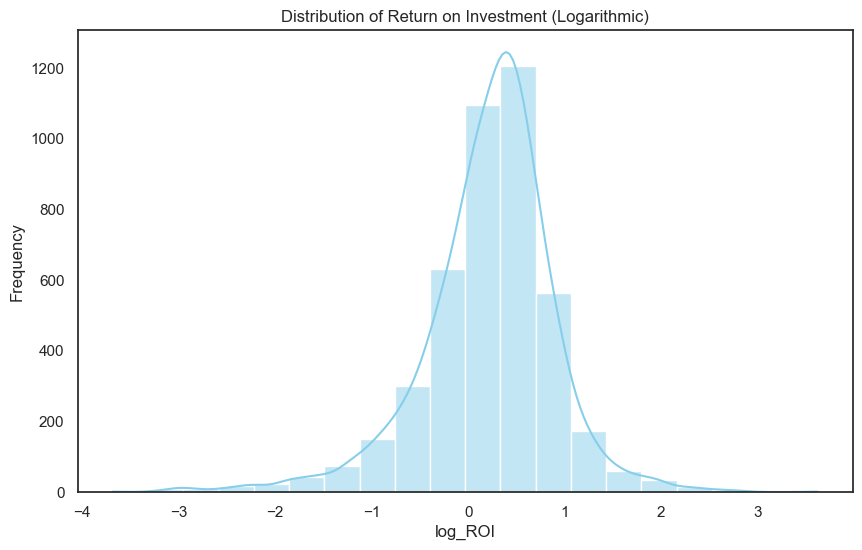

In [16]:
# df_budget["log_ROI"] = np.log10(df_budget["ROI"])

# filter extreme values (potential incorrect data)
df_budget = df_budget[(df_budget["log_ROI"] > -5) & (df_budget["log_ROI"] < 5)]

plot_distribution(
    df_budget, "log_ROI", title="Distribution of Return on Investment (Logarithmic)"
)

In [18]:
# Add log_ROI column and filter extreme values
df_budget["log_ROI"] = np.log10(df_budget["ROI"] + 1)
df_budget_filtered = df_budget[(df_budget["log_ROI"] > -5) & (df_budget["log_ROI"] < 5)]

# Example usage
plot_roi_distribution(
    df_budget_filtered,
    column="log_ROI",
    bins=50,
    kde=False,
    color="skyblue",
    title="Distribution of Return on Investment (ROI)",
    xlabel="ROI Logarithmic",
)

We can see that some movies have a very high ROI (outliers) (even after applying log10). We will investigate this further below.

In [20]:
# Example Usage
plot_roi_by_genre(df_budget)

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - Horror and Indie films have the highest average ROI but also exhibit the largest confidence intervals. This suggests that while they can deliver exceptional returns, their performance is highly variable.
  - Fantasy and Family films balance moderate ROI with lower variability, as indicated by their narrower confidence intervals. These genres may offer more reliable returns, appealing to studios looking for safer, less volatile investments.
  - Genres like Action/Adventure and Crime Thriller show both low average ROI and relatively smaller confidence intervals. This suggests they consistently underperform, potentially due to high production costs or a saturated market.
</div>

In [21]:
# 5 movies with the highest ROI and their genres
top_5_roi_movies = df_budget.nlargest(5, "ROI")
top_5_roi_movies[
    ["movie_name", "genres_list", "inflated_budget", "inflated_revenue", "ROI"]
]

,movie_name,genres_list,inflated_budget,inflated_revenue,ROI
3997,The Blair Witch Project,"[Horror, Indie, Supernatural, Cult, Mystery, A...",8.645013e+04,3.582480e+08,4142.984983
7422,Eraserhead,"[Science Fiction, Horror, Indie, Experimental ...",3.959970e+04,2.771979e+07,699.000000
5438,Pink Flamingos,"[Crime Fiction, Horror, Gross-out film, Gay, C...",6.887412e+04,4.017657e+07,582.333333
308,The Birth of a Nation,"[Silent film, Indie, Costume drama, Epic, Blac...",2.374350e+06,1.187175e+09,499.000000
4630,Super Size Me,"[Culture & Society, Business, Indie, Drama, Co...",8.259313e+04,3.811991e+07,460.538462


<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - As it is shown on the table above, the 5 movies with the highest ROI are all from either the Horror or Indie genre. This suggests that these genres have the potential to deliver exceptional returns.
  - As an extraordinary example, the movie "The Blair Witch Project" had a budget of $60,000 and a revenue of $250,000,000 (these values are before inlation adjustment), resulting in an ROI of ~4143.
</div>

In [26]:
# Filter for top 20 genres
df_budget_exploded = df_budget.explode("genres_list")
genre_counts = df_budget_exploded["genres_list"].value_counts()
top_20_genres = genre_counts.head(20).index.tolist()
df_budget_filtered = df_budget_exploded[
    df_budget_exploded["genres_list"].isin(top_20_genres)
]

df_budget_filtered["log_ROI"] = np.log10(df_budget_filtered["ROI"] + 1)
plot_roi_per_genre_boxplot(df_budget)

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - Many movies have a negative ROI, meaning that their revenue was smaller than their budget.
  - Some genres, as for example Horror, have a very high ROI in some cases, and in general their ROI is higher than others.
  - The ROI distribution for most genres seems to be highly skewed. 
</div>

#### Distribution of Budget per Genre

In [28]:
plot_budget_per_genre(df_budget_filtered, top_20_genres)

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - Horror and Indie films have the lowest budgets on average, with a wide range, suggesting they often operate on smaller scales but occasionally receive larger investments. This aligns with their high ROI potential but also highlights their variability.
  - Action, Science Fiction, and Fantasy genres tend to have the highest average budgets, as seen from their elevated median and upper ranges. These genres likely demand significant resources for special effects, set design, and large-scale production.
</div>

#### Revenue to Budget Ratio Analysis

In [22]:
df_budget

,movie_name,inflated_budget,inflated_revenue,release_year,genres_list,log_revenue,log_budget,ROI,log_ROI,log_revenue_to_budget_ratio
1,Alexander's Ragtime Band,3.406370e+07,6.131466e+07,1938,"[Musical, Comedy, Black-and-white]",7.787564,7.532292,0.800000,-0.096910,0.255273
2,Henry V,1.742456e+07,1.967252e+07,1989,"[Costume drama, War film, Epic, Period piece, ...",7.293860,7.241162,0.129011,-0.889373,0.052698
3,Mary Poppins,4.642804e+07,7.913870e+08,1964,"[Children's/Family, Musical, Fantasy, Comedy, ...",8.898389,7.666780,16.045454,1.205352,1.231609
5,Baby Boy,2.168739e+07,3.982571e+07,2001,"[Crime Fiction, Drama, Coming of age]",7.600164,7.336207,0.836353,-0.077610,0.263956
7,The Gods Must Be Crazy,1.456207e+07,9.998836e+07,1980,"[Adventure, Action/Adventure, Indie, World cin...",7.999949,7.163223,5.866357,0.768368,0.836726
...,...,...,...,...,...,...,...,...,...,...
9524,Trois,2.787540e+05,1.617147e+06,2000,"[Thriller, Erotic thriller, Romance Film, Psyc...",6.208749,5.445221,4.801340,0.681362,0.763528
9525,Twister,1.407756e+08,7.566255e+08,1996,"[Action/Adventure, Disaster]",8.878881,8.148528,4.374690,0.640947,0.730353
9526,Source Code,3.414358e+07,1.572021e+08,2011,"[Thriller, Science Fiction, Action/Adventure, ...",8.196458,7.533309,3.604147,0.556802,0.663149
9530,Coming to America,7.915112e+07,5.860274e+08,1988,"[Romantic comedy, Comedy of manners, Drama, Co...",8.767918,7.898457,6.403905,0.806445,0.869461


In [40]:
plot_revenue_to_budget_ratio(df_budget)

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>
  
  - The green line (Revenue = 10 × Budget) marks a strong profitability benchmark, but very few movies surpass it, which shows exceptional hits are rare.

  - Most movies with lower budgets have a higher revenue-to-budget ratio, which suggests that it is more likely to times your budget with a smaller number to get the revenue in the film industry.

  - High-budget films tend to cluster around the black line, that shows tighter revenue-to-budget ratios, likely due to large-scale production consistency but smaller risk of extreme profitability.


</div>

### Statistical Analysis

<div class="alert alert-success"> 💭 <strong>Idea:</strong> 

 - Determine the strength and direction of the relationship between budget and revenue. 
 - Identify if higher budget movies result in higher revenues, and if this varies by genre. 
 - Predict box office revenue based on movie budget.
 </div> 
<div class="alert alert-warning"> 🛠️ <strong>Methods:</strong> 

 - Calculate the Pearson and Spearman correlation coefficients between budget and revenue, both on the full data set and for each genre individually.
 - Use linear regression to model the relationship between log-transformed budget and log-transformed box office revenue.
 </div>

#### Correlation Analysis

In [41]:
# Pearson correlation between log-transformed budget and revenue
corr_pearson = df_budget[["log_budget", "log_revenue"]].corr(method="pearson")
print("Pearson Correlation Coefficient:")
print(corr_pearson)

# spearman correlation between log-transformed budget and revenue
corr_spearman = df_budget[["log_budget", "log_revenue"]].corr(method="spearman")
print("\nSpearman Correlation Coefficient:")
print(corr_spearman)

Pearson Correlation Coefficient:
             log_budget  log_revenue
log_budget     1.000000     0.623765
log_revenue    0.623765     1.000000

Spearman Correlation Coefficient:
             log_budget  log_revenue
log_budget     1.000000     0.640116
log_revenue    0.640116     1.000000


<div class="alert alert-info">
  💡 <strong>Discussion:</strong>
  - The correlation between log-transformed budget and revenue is 0.623 (Pearson) and 0.640 (Spearman), indicating an important positive relationship.
</div>

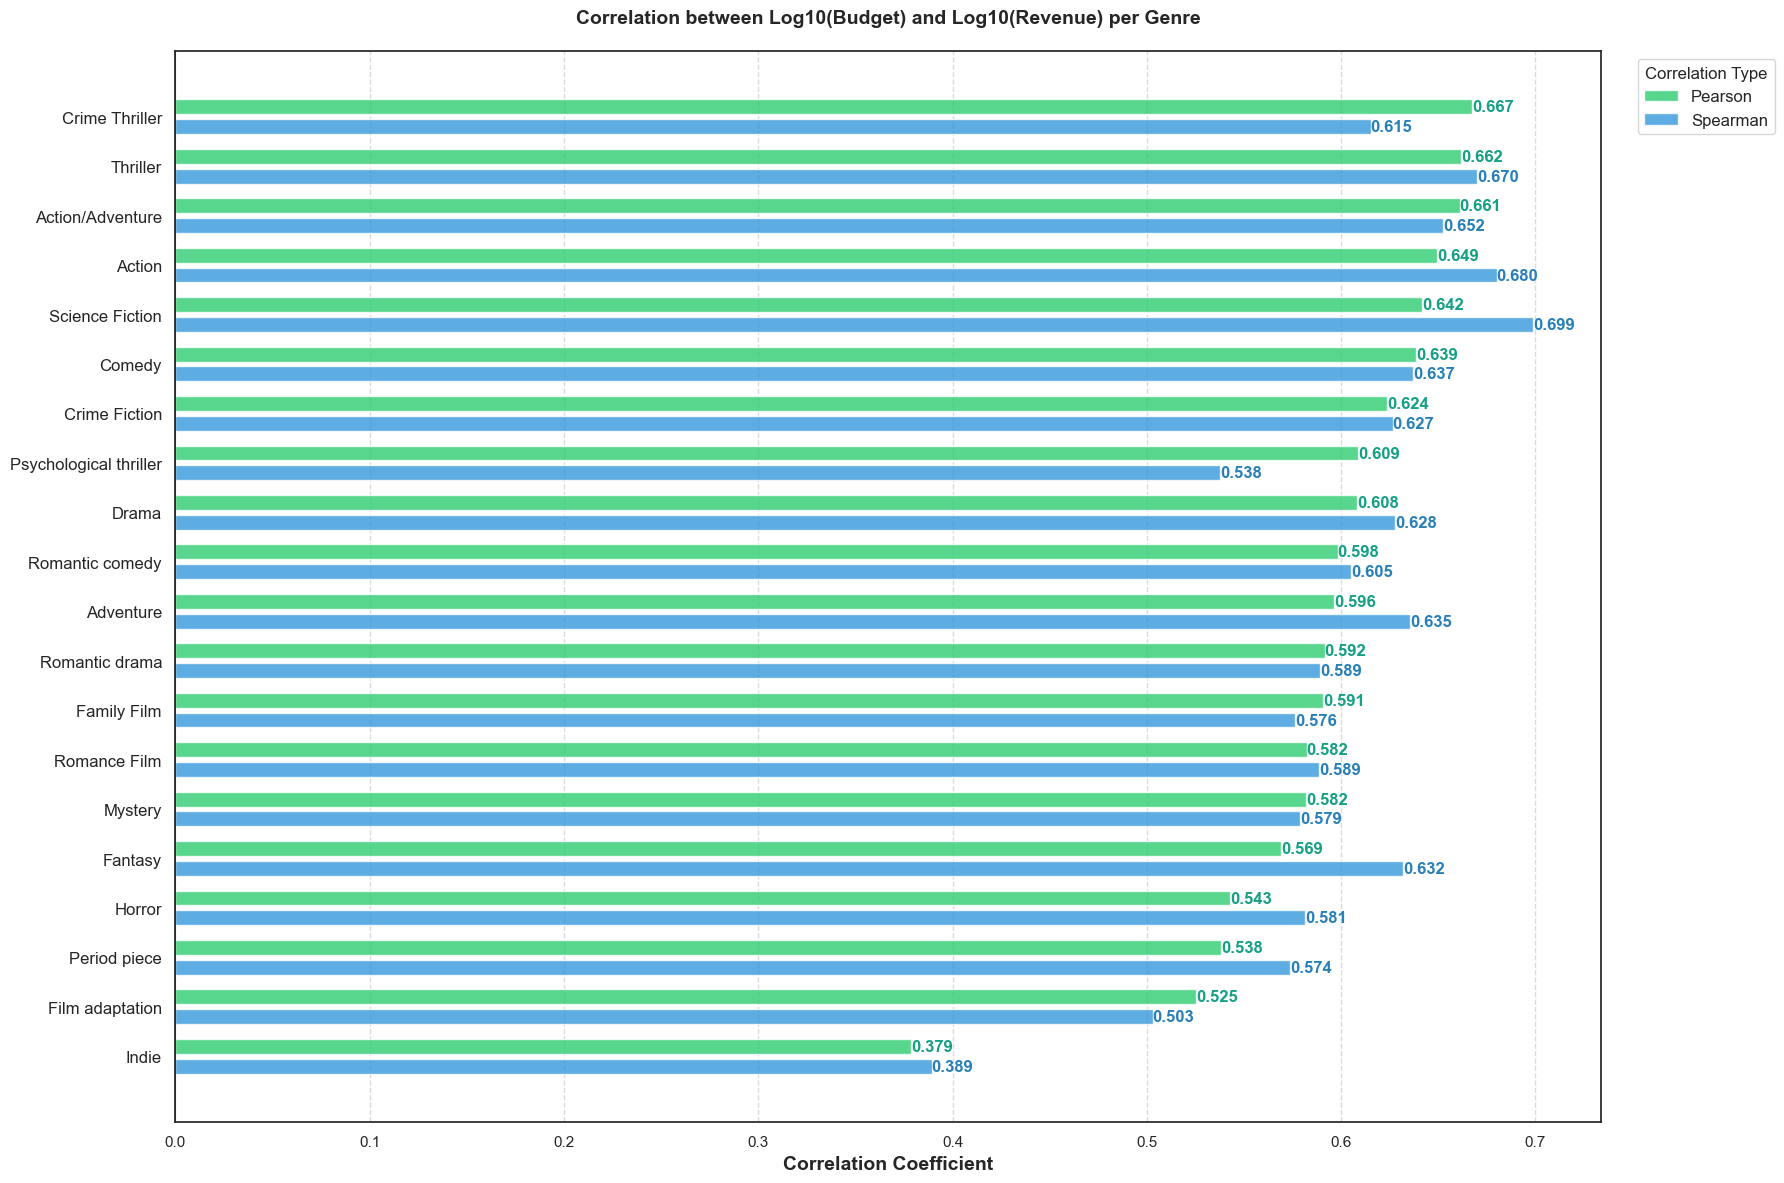

In [42]:
# calculate the correlation for each genre
genre_corrs = []
for genre in top_20_genres:
    df_budget_genre = df_budget[
        df_budget["genres_list"].apply(lambda x: genre in x)
    ]  # filter for movies that contain that genre
    if len(df_budget_genre) > 0:  # only proceed if there are movies in this genre
        corr_pearson = (
            df_budget_genre[["inflated_budget", "inflated_revenue"]]
            .apply(np.log10)
            .corr(method="pearson")
        )  # calculate pearson correlation
        corr_spearman = (
            df_budget_genre[["inflated_budget", "inflated_revenue"]]
            .apply(np.log10)
            .corr(method="spearman")
        )  # calculate spearman correlation
        genre_corrs.append(
            {
                "Genre": genre,
                "Pearson": corr_pearson.iloc[0, 1],  # take the correlation
                "Spearman": corr_spearman.iloc[0, 1],  # take the correlation
            }
        )

genre_corrs = pd.DataFrame(genre_corrs)
genre_corrs.set_index("Genre", inplace=True)

plot_genre_correlation_bars(
    genre_corrs,
    title="Correlation between Log10(Budget) and Log10(Revenue) per Genre",
)
# # sort by pearson
# genre_corrs.sort_values(by="Pearson", ascending=False)

In [44]:
import plotly.graph_objects as go
import plotly.express as px

# Assuming genre_corrs is already defined as in your code
# genre_corrs: DataFrame with 'Pearson' and 'Spearman' columns, index as 'Genre'

plot_budget_correlation_per_genre(genre_corrs)

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - Correlations between budget and revenue mostly show similar values across genres.
  - The correlation between budget and revenue is highest for Crime Thriller and lowest for Indie movies for the Top 20 genres.
</div>

#### Budget vs Revenue Log-Log Scatter Plot

In [45]:
# rows where log_budget is bigger than log_revenue
df_budget[df_budget["log_budget"] > df_budget["log_revenue"]]

,movie_name,inflated_budget,inflated_revenue,release_year,genres_list,log_revenue,log_budget,ROI,log_ROI,log_revenue_to_budget_ratio
0,Ghosts of Mars,3.795294e+07,1.899115e+07,2001,"[Thriller, Science Fiction, Horror, Adventure,...",7.278551,7.579245,-0.499613,-0.300694,-0.300694
19,Star!,9.880889e+07,2.760025e+07,1968,"[Biography, Musical, Drama, Biopic [feature], ...",7.440913,7.994796,-0.720670,-0.553883,-0.553883
22,Things to Do in Denver When You're Dead,1.260018e+07,8.342532e+05,1995,"[Thriller, Crime Fiction, Crime Comedy, Gangst...",5.921298,7.100377,-0.933790,-1.179079,-1.179079
26,The Astronaut Farmer,1.547729e+07,1.325200e+07,2006,"[Science Fiction, Americana, Drama, Adventure,...",7.122281,7.189695,-0.143778,-0.067414,-0.067414
32,Vanishing on 7th Street,1.100670e+07,1.176266e+06,2010,"[Thriller, Horror, Supernatural, Gothic Film, ...",6.070506,7.041657,-0.893132,-0.971152,-0.971152
...,...,...,...,...,...,...,...,...,...,...
9474,Renaissance,2.143010e+07,2.180331e+06,2006,"[Thriller, Science Fiction, Future noir, Black...",6.338523,7.331024,-0.898258,-0.992502,-0.992502
9479,The Matriarch,1.620556e+06,5.035300e+05,2007,"[Comedy film, Drama]",5.702025,6.209664,-0.689286,-0.507639,-0.507639
9481,Revolution,6.247475e+07,8.000650e+05,1985,"[Costume drama, Period piece, Drama, War film]",5.903125,7.795705,-0.987194,-1.892579,-1.892579
9514,Noises Off...,2.052562e+07,3.900120e+06,1992,"[Parody, Comedy, Slapstick]",6.591078,7.312296,-0.809988,-0.721218,-0.721218


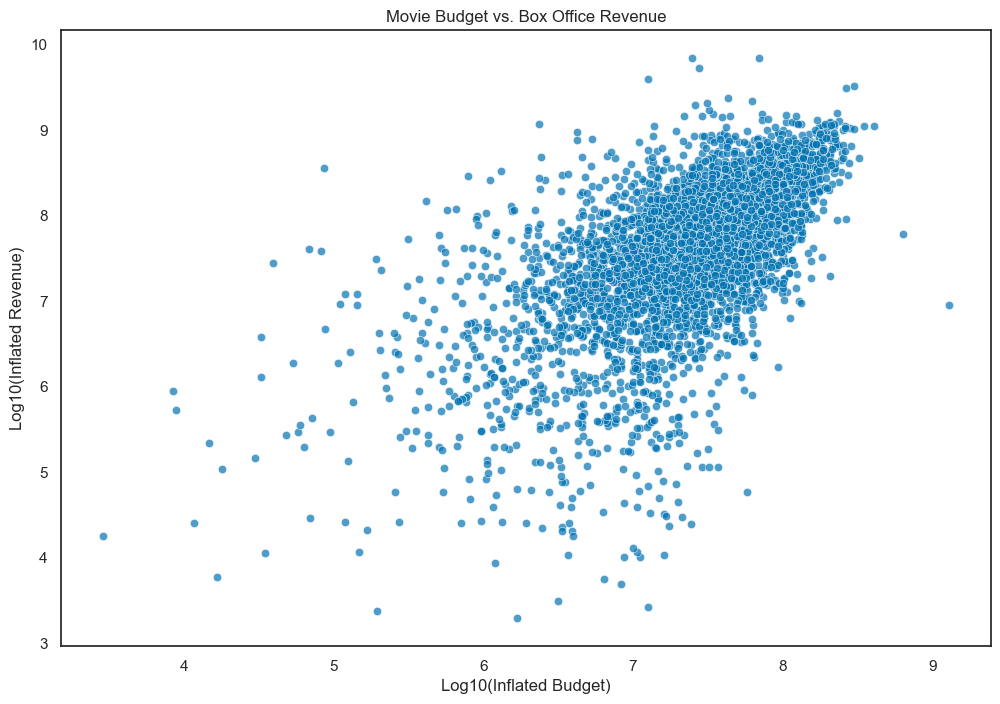

In [46]:
plot_scatter(
    df_budget,
    x="log_budget",
    y="log_revenue",
    title="Movie Budget vs. Box Office Revenue",
    xlabel="Log10(Inflated Budget)",
    ylabel="Log10(Inflated Revenue)",
)

As can be seen in the scatter plot, it is hard to see the density of the points. A hexbin plot might be better.

In [67]:
plot_budget_vs_revenue(df_budget)

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - The hexbin plot provides a better view of data density and confirms the strong positive correlation between budget and revenue.
</div>

#### Regression Analysis

In [48]:
X = df_budget["log_budget"]
Y = df_budget["log_revenue"]

# add constant to the independent variable
X = sm.add_constant(X)

# fit the model
model = sm.OLS(Y, X).fit()

# model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_revenue   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     2805.
Date:                Thu, 19 Dec 2024   Prob (F-statistic):               0.00
Time:                        03:07:28   Log-Likelihood:                -4581.5
No. Observations:                4406   AIC:                             9167.
Df Residuals:                    4404   BIC:                             9180.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8753      0.127      6.902      0.000       0.627       1.124
log_budget     0.9102      0.017     52.961      0.000       0.876       0.944
==============================================================================
Omnibus:                      796.601   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2432.535
Skew:                          -0.929   Prob(JB):                         0.00
Kurtosis:                       6.130   Cond. No.                         92.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - Very strong positive relationship between budget and revenue (coefficient = 0.91), indicating that a 1% increase in log(budget) corresponds to approximately 0.91% increase in log(revenue), with high statistical significance (p < 0.001).

  - The model explains about 39% of the variance in movie revenues (R-squared = 0.389), so it suggests that while budget is an important predictor, other factors also significantly influence movie revenue.
</div>